In [10]:
from AnalyzeBestParameterConfig import *

import sys
import os
import pandas as pd
from tabulate import tabulate

df_all = pd.read_json('parameterstudy_greedy.json', orient='records')

In [39]:
# Deactivate printing for this block
original_stdout = sys.stdout
sys.stdout = open(os.devnull, "w")

number = [1, 8, 16, 32, 40]
numberParamComb = [1, 2, 3]
results = []

for nuP in numberParamComb:
    for nu in number:
        average_percent_dif, average_runtime = analyze_parameters(df_all, n=nu, num_param_comb=nuP)
        # Runde die Werte auf zwei Dezimalstellen
        results.append([nuP, nu, round(average_percent_dif, 2), round(average_runtime, 2)])


results.sort(key=lambda x: x[2])

# Erstelle die Tabelle aus results
df = pd.DataFrame(results, columns=['Number of Parameter Combinations', 'Number of Best Combinations', 'Average Percent Difference', 'Average Runtime'])

# Wiederherstellen der Standardausgabe
sys.stdout.close()
sys.stdout = original_stdout


# Finde die Kombination mit der kleinsten Percent Difference für jede Anzahl von Parameterkombinationen
min_percent_diff_df = df.loc[df.groupby('Number of Parameter Combinations')['Average Percent Difference'].idxmin()]

# Tabelle schön formatieren
print("\nKombinationen mit der kleinsten Percent Difference für jede Anzahl von Parameterkombinationen:")
print(tabulate(min_percent_diff_df, headers='keys', tablefmt='fancy_grid', floatfmt=".2f"))


# Tabelle schön formatieren
print("Full DataFrame:")
print(tabulate(df, headers='keys', tablefmt='fancy_grid', floatfmt=".2f"))



Kombinationen mit der kleinsten Percent Difference für jede Anzahl von Parameterkombinationen:
╒════╤════════════════════════════════════╤═══════════════════════════════╤══════════════════════════════╤═══════════════════╕
│    │   Number of Parameter Combinations │   Number of Best Combinations │   Average Percent Difference │   Average Runtime │
╞════╪════════════════════════════════════╪═══════════════════════════════╪══════════════════════════════╪═══════════════════╡
│  9 │                               1.00 │                          1.00 │                         0.42 │              4.43 │
├────┼────────────────────────────────────┼───────────────────────────────┼──────────────────────────────┼───────────────────┤
│  3 │                               2.00 │                          8.00 │                         0.23 │             17.56 │
├────┼────────────────────────────────────┼───────────────────────────────┼──────────────────────────────┼───────────────────┤
│  0 │         

In [32]:
analyze_parameters(df_all, n=1, num_param_comb=3)

Beste Parameterkombination 1 insgesamt: ('OnePerDay', 'WithDistanceToMainTask', 1.0, 0)
Beste Parameterkombination 2 insgesamt: ('MIP', 'WithDistanceToMainAndCloseTasks', 0.5, 100)
Beste Parameterkombination 3 insgesamt: ('OnePerDay', 'WithDistanceToMainAndCloseTasks', 2.0, 20)
721: Gewählte Parameterkombination: ('OnePerDay', 'WithDistanceToMainAndCloseTasks', 2.0, 20), Bester Profit: 739, Profit mit gewählter Parameterkombination: 739, Unterschied: 0, Prozentuale Abweichung: 0.00%, Gesamtlaufzeit: 18.875392437000002
722: Gewählte Parameterkombination: ('OnePerDay', 'WithDistanceToMainAndCloseTasks', 2.0, 20), Bester Profit: 736, Profit mit gewählter Parameterkombination: 731, Unterschied: 5, Prozentuale Abweichung: 0.68%, Gesamtlaufzeit: 18.9213638305
751: Gewählte Parameterkombination: ('OnePerDay', 'WithDistanceToMainTask', 1.0, 0), Bester Profit: 1583, Profit mit gewählter Parameterkombination: 1583, Unterschied: 0, Prozentuale Abweichung: 0.00%, Gesamtlaufzeit: 30.0859069824
752:

(0.09090506829918374, 34.641598343850006)

In [13]:
# Funktion zur Erstellung der Farbskala für die Profit-Spalte
def color_scale(val, best_vals, worst_vals):
    """
    Markiert den besten Wert in Dunkelgrün, die Plätze 2 bis 5 in Grün und die letzten 5 Plätze in Rot.
    """
    if pd.isna(val):
        return ''
    
    # Farben zuweisen
    if val == best_vals[4]:
        color = 'background-color: rgb(0, 100, 0)'  # Dunkelgrün für den besten Wert
    elif val in best_vals[0:4]:
        color = 'background-color: rgb(0, 255, 0)'  # Grün für die Plätze 2 bis 5
    elif val in worst_vals:
        color = 'background-color: rgb(255, 0, 0)'  # Rot für die letzten 5 Plätze
    else:
        color = ''
    
    return color

# Erstellen Sie die Formatierungsfunktionen für jede Instanz
def highlight_instanz_scale(df):
    styles = pd.DataFrame('', index=df.index, columns=df.columns)
    for instanz in df['Instanz'].unique():
        subset = df[df['Instanz'] == instanz]
        sorted_profit = subset['Profit'].sort_values()
        
        # Die besten 5 Werte (einschließlich des besten)
        best_vals = sorted_profit.tail(5).tolist()
        # Die schlechtesten 5 Werte
        worst_vals = sorted_profit.head(5).tolist()
        
        # Farbanpassung auf die Profit-Spalte der aktuellen Instanz anwenden
        styles.loc[subset.index, 'Profit'] = subset['Profit'].apply(
            lambda val: color_scale(val, best_vals, worst_vals)
        )
    return styles

# Funktion zur Formatierung der Trennlinie zwischen Instanzen
def add_instance_separator(df):
    styles = pd.DataFrame('', index=df.index, columns=df.columns)
    unique_instanz = df['Instanz'].unique()
    for i, instanz in enumerate(unique_instanz):
        indices = df[df['Instanz'] == instanz].index
        if i < len(unique_instanz) - 1:
            next_instanz_start = df[df['Instanz'] == unique_instanz[i + 1]].index[0]
            styles.loc[indices[-1], :] = 'border-bottom: 2px solid black'  # Fette Linie am Ende der Instanz
    return styles

# Stilisiert den kombinierten DataFrame mit der Farbskala und Trennlinien
styled_df_all = df_all.style.apply(lambda df: highlight_instanz_scale(df), axis=None)\
                          .apply(lambda df: add_instance_separator(df), axis=None)\
                          .format({
                              'Profit': '{:,.0f}',
                              'Anzahl Tasks': '{:,.0f}',
                              'a-Wert': '{:.1f}',
                              'b-Wert': '{:.0f}',
                              'runtime': '{:.2f}'  # Formatierung für runtime, z.B. zwei Dezimalstellen
                          })


# Printe die Summe der Runtimes in Minuten
print('Summe der Runtimes in Stunden: ' + str(df_all['runtime'].sum() / 60 /60))
# Anzeige des stilisierten kombinierten DataFrames
styled_df_all

Summe der Runtimes in Stunden: 1.0201428633929168


,Instanz,MainTaskPlanner,AttractivenessFunction,a-Wert,b-Wert,Anzahl Tasks,Profit,runtime
0,721,OnePerDay,OnlyDistanceToNextTask,0.5,0,257,687,1.16
1,721,OnePerDay,OnlyDistanceToNextTask,1.0,0,253,703,1.18
2,721,OnePerDay,OnlyDistanceToNextTask,1.5,0,250,704,1.11
3,721,OnePerDay,OnlyDistanceToNextTask,2.0,0,250,704,1.15
4,721,OnePerDay,WithDistanceToMainTask,0.5,0,266,718,1.25
5,721,OnePerDay,WithDistanceToMainTask,1.0,0,258,723,1.25
6,721,OnePerDay,WithDistanceToMainTask,1.5,0,257,723,1.20
7,721,OnePerDay,WithDistanceToMainTask,2.0,0,257,723,1.25
8,721,OnePerDay,WithDistanceToMainAndCloseTasks,0.5,20,272,712,8.82
9,721,OnePerDay,WithDistanceToMainAndCloseTasks,0.5,50,267,724,8.74


In [38]:
# Funktion zur Erstellung eines DataFrames mit den ersten 5 und letzten 5 Zeilen jeder Instanz, sortiert nach Profit
def select_top_and_bottom_sorted(df, n=5):
    sorted_df = df.sort_values(by='Profit', ascending=False)
    top_and_bottom = pd.concat([sorted_df.head(n), sorted_df.tail(n)])
    return top_and_bottom

# DataFrame für die gewünschten Zeilen jeder Instanz erstellen, sortiert nach Profit
selected_rows_sorted = pd.concat([select_top_and_bottom_sorted(df_all[df_all['Instanz'] == instanz]) for instanz in df_all['Instanz'].unique()])

# Stil für den ausgewählten DataFrame erstellen
styled_selected_rows_sorted = selected_rows_sorted.style.apply(lambda df: highlight_instanz_scale(df), axis=None)\
                                          .apply(lambda df: add_instance_separator(df), axis=None)\
                                          .format({
                                              'Profit': '{:,.0f}',
                                              'Anzahl Tasks': '{:,.0f}',
                                              'a-Wert': '{:.1f}',
                                              'b-Wert': '{:.0f}',
                                              'runtime': '{:.2f}'  # Formatierung für runtime, z.B. zwei Dezimalstellen
                                          })

# Anzeige des stilisierten DataFrames
styled_selected_rows_sorted



,Instanz,MainTaskPlanner,AttractivenessFunction,a-Wert,b-Wert,Anzahl Tasks,Profit,runtime
17,721,OnePerDay,WithDistanceToMainAndCloseTasks,2.0,20,262,739,8.75
13,721,OnePerDay,WithDistanceToMainAndCloseTasks,1.0,100,262,734,8.71
14,721,OnePerDay,WithDistanceToMainAndCloseTasks,1.5,20,260,733,8.77
15,721,OnePerDay,WithDistanceToMainAndCloseTasks,1.5,50,260,732,8.70
12,721,OnePerDay,WithDistanceToMainAndCloseTasks,1.0,50,262,732,8.74
1,721,OnePerDay,OnlyDistanceToNextTask,1.0,0,253,703,1.18
20,721,MIP,OnlyDistanceToNextTask,0.5,0,260,698,1.29
21,721,MIP,OnlyDistanceToNextTask,1.0,0,253,698,1.25
28,721,MIP,WithDistanceToMainAndCloseTasks,0.5,20,265,690,8.94
0,721,OnePerDay,OnlyDistanceToNextTask,0.5,0,257,687,1.16


Daten fehlen für eine oder beide Instanzen: 7_2_1, 7_2_2
Daten fehlen für eine oder beide Instanzen: 7_5_1, 7_5_2
Daten fehlen für eine oder beide Instanzen: 7_8_1, 7_8_2
Daten fehlen für eine oder beide Instanzen: 7_10_1, 7_10_2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


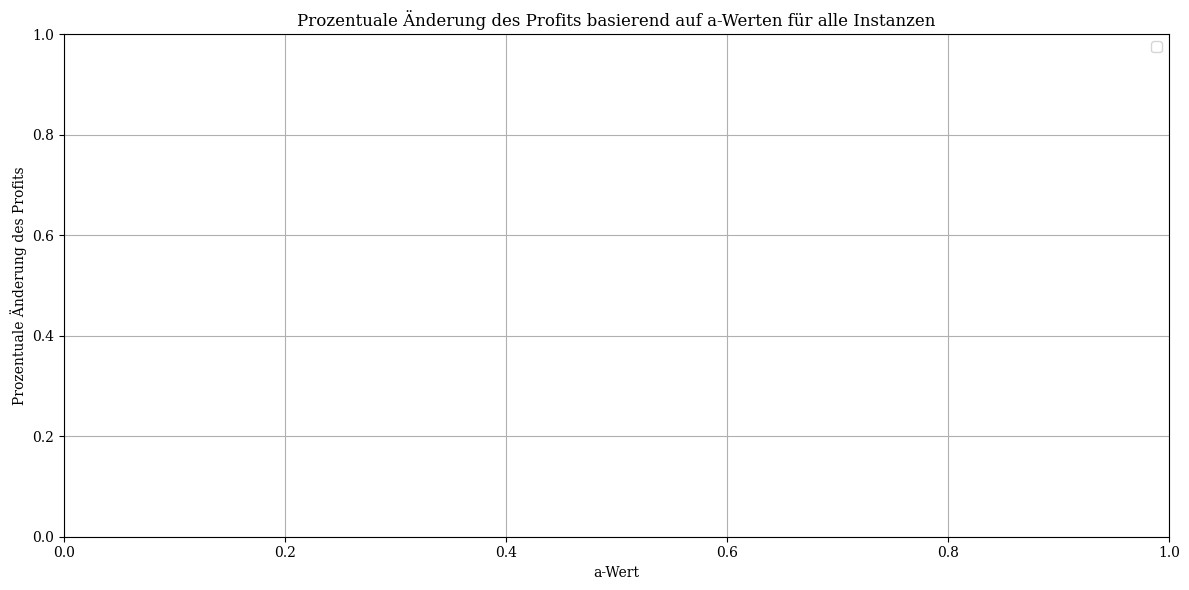

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Beispiel-Daten für den Plot
instance_pairs = [
    ('7_2_1', '7_2_2'),
    ('7_5_1', '7_5_2'),
    ('7_8_1', '7_8_2'),
    ('7_10_1', '7_10_2')
]

# Farben definieren für die Instanzen
colors = {
    '7_2_1': 'tab:blue',
    '7_2_2': 'tab:orange',
    '7_5_1': 'tab:green',
    '7_5_2': 'tab:red',
    '7_8_1': 'tab:purple',
    '7_8_2': 'tab:brown',
    '7_10_1': 'tab:pink',
    '7_10_2': 'tab:gray'
}

# Initialisierung des Plots
plt.figure(figsize=(12, 6))

# Set the font to serif
plt.rcParams["font.family"] = "serif"

# Durchlaufen der Instanzenpaare
for inst1, inst2 in instance_pairs:
    # Filtere den DataFrame für die aktuelle Instanz
    subset1 = df_all[df_all['Instanz'] == inst1]
    subset2 = df_all[df_all['Instanz'] == inst2]
    
    # Prüfen, ob die Subsets leer sind
    if subset1.empty or subset2.empty:
        print(f'Daten fehlen für eine oder beide Instanzen: {inst1}, {inst2}')
        continue
    
    # Sammeln der Daten für die erste Instanz des Paares
    a_values1 = subset1['a-Wert'].values
    profits1 = subset1['Profit'].values

    # Sammeln der Daten für die zweite Instanz des Paares
    a_values2 = subset2['a-Wert'].values
    profits2 = subset2['Profit'].values

    # Berechnung des Mittelwerts des Profits
    mean_profit1 = np.mean(profits1)
    mean_profit2 = np.mean(profits2)

    # Berechnung der prozentualen Änderungen im Profit im Vergleich zum Mittelwert
    percent_change1 = 100 * (np.array(profits1) - mean_profit1) / mean_profit1
    percent_change2 = 100 * (np.array(profits2) - mean_profit2) / mean_profit2

    # Plot für beide Instanzen
    plt.plot(a_values1, percent_change1, marker='o', color=colors.get(inst1, 'black'), label=f'Instanz {inst1}')
    plt.plot(a_values2, percent_change2, marker='s', color=colors.get(inst2, 'black'), label=f'Instanz {inst2}')

    # Ermitteln des besten a-Werts basierend auf dem höchsten Profit
    if len(profits1) > 0:
        best_a_value1 = a_values1[np.argmax(profits1)]
        best_profit1 = max(profits1)
        print(f'Instanz {inst1} - Höchster Profit: {best_profit1} bei a-Wert: {best_a_value1}')
    
    if len(profits2) > 0:
        best_a_value2 = a_values2[np.argmax(profits2)]
        best_profit2 = max(profits2)
        print(f'Instanz {inst2} - Höchster Profit: {best_profit2} bei a-Wert: {best_a_value2}')

# Achsenbeschriftungen und Titel
plt.xlabel('a-Wert')
plt.ylabel('Prozentuale Änderung des Profits')
plt.title('Prozentuale Änderung des Profits basierend auf a-Werten für alle Instanzen')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()

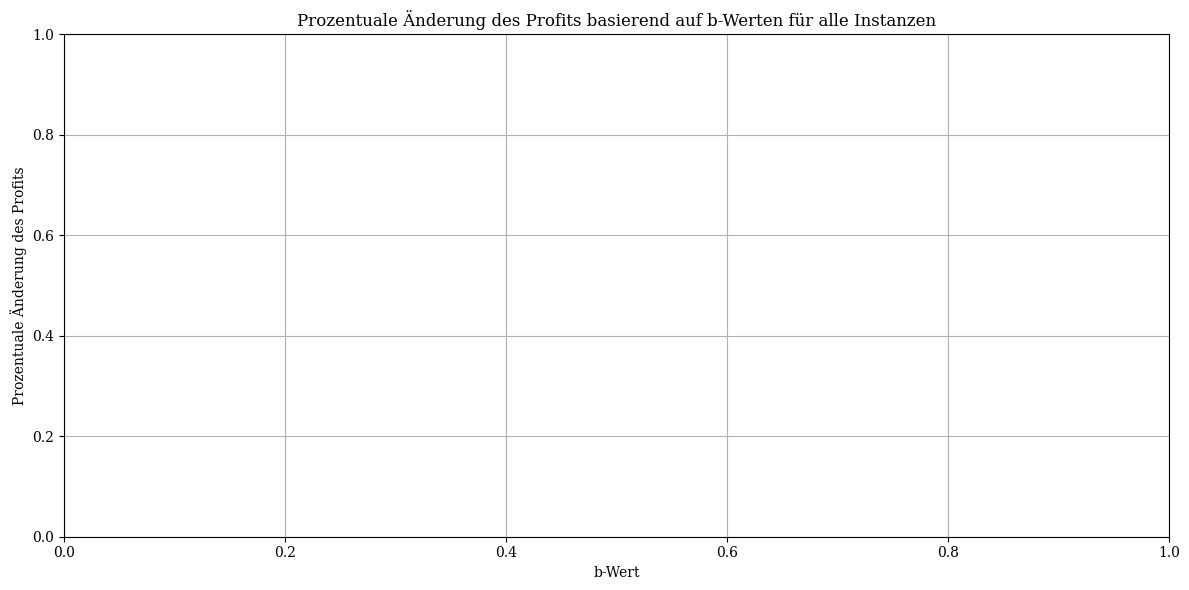

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Beispiel-Daten für den Plot
instance_pairs = [
    ('7_2_1', '7_2_2'),
    ('7_5_1', '7_5_2'),
    ('7_8_1', '7_8_2'),
    ('7_10_1', '7_10_2')
]

# Farben definieren für die Instanzen
colors = {
    '7_2_1': 'tab:blue',
    '7_2_2': 'tab:orange',
    '7_5_1': 'tab:green',
    '7_5_2': 'tab:red',
    '7_8_1': 'tab:purple',
    '7_8_2': 'tab:brown',
    '7_10_1': 'tab:pink',
    '7_10_2': 'tab:gray'
}

# Initialisierung des Plots
plt.figure(figsize=(12, 6))

# Set the font to serif
plt.rcParams["font.family"] = "serif"

# Flag für die Legende
has_labels = False

# Durchlaufen der Instanzenpaare
for inst1, inst2 in instance_pairs:
    b_values1 = []
    profits1 = []
    b_values2 = []
    profits2 = []

    # Sammeln der Daten für die erste Instanz des Paares
    subset1 = df_all[df_all['Instanz'] == inst1]
    if not subset1.empty:
        b_values1 = subset1['b-Wert'].values
        profits1 = subset1['Profit'].values

        # Berechnung des Mittelwerts des Profits
        mean_profit1 = np.mean(profits1)
        percent_change1 = 100 * (np.array(profits1) - mean_profit1) / mean_profit1

        # Ermitteln des besten b-Werts basierend auf dem höchsten Profit
        if len(profits1) > 0:
            best_b_value1 = b_values1[np.argmax(profits1)]
            best_profit1 = max(profits1)
            print(f'Instanz {inst1} - Höchster Profit: {best_profit1} bei b-Wert: {best_b_value1}')
            
            # Plot für die erste Instanz des Paares
            plt.plot(b_values1, percent_change1, marker='o', color=colors.get(inst1, 'black'), label=f'Instanz {inst1}')
            has_labels = True

    # Sammeln der Daten für die zweite Instanz des Paares
    subset2 = df_all[df_all['Instanz'] == inst2]
    if not subset2.empty:
        b_values2 = subset2['b-Wert'].values
        profits2 = subset2['Profit'].values

        # Berechnung des Mittelwerts des Profits
        mean_profit2 = np.mean(profits2)
        percent_change2 = 100 * (np.array(profits2) - mean_profit2) / mean_profit2

        # Ermitteln des besten b-Werts basierend auf dem höchsten Profit
        if len(profits2) > 0:
            best_b_value2 = b_values2[np.argmax(profits2)]
            best_profit2 = max(profits2)
            print(f'Instanz {inst2} - Höchster Profit: {best_profit2} bei b-Wert: {best_b_value2}')
            
            # Plot für die zweite Instanz des Paares
            plt.plot(b_values2, percent_change2, marker='s', color=colors.get(inst2, 'black'), label=f'Instanz {inst2}')
            has_labels = True

# Achsenbeschriftungen und Titel
plt.xlabel('b-Wert')
plt.ylabel('Prozentuale Änderung des Profits')
plt.title('Prozentuale Änderung des Profits basierend auf b-Werten für alle Instanzen')
plt.grid(True)

# Legende hinzufügen, wenn Labels vorhanden sind
if has_labels:
    plt.legend()


plt.tight_layout()
plt.show()